In [1319]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import netCDF4
import gsw # this will be VERY useful https://github.com/TEOS-10/GSW-Python

# 1. Download synthetic argo file (= S-file)

In [1320]:
# import requests
# import urllib 
# import ftplib
import wget
import os

def download_float(dac, wmo):
    """
    dac : data center, e.g. 'coriolis'
    wmo : world id of the float (unique), e.g. 6901866
    """
    
    # check if float folder exists
    if(os.path.isdir('./floats') == False):
        print("Directory 'floats' does not exist")
        print("It's being created in your current path")
        os.mkdir(os.path.join(os.getcwd(),'floats'))
    # check if file already exists in that folder
    if(os.path.isfile(os.getcwd()+'/floats/'+str(wmo)+'_Sprof.nc') == False):
        print("File does not exist")
        print("File is being downloaded")
        print("...")
        base_url = 'ftp://ftp.ifremer.fr/ifremer/argo/dac/'
        full_url = base_url+dac+'/'+str(wmo)+'/'
        link = full_url+str(wmo)+'_Sprof.nc'
        wget.download(link, out = os.getcwd()+'/floats/')
        print("Done !")
    else:
        print("File already exists, moving on.")

In [1321]:
download_float('coriolis',6900798)
#download_float('coriolis',6901866) # Black Sea, just for testing
download_float('coriolis',6900799)

File already exists, moving on.
File already exists, moving on.


# 2. Extract data from NetCDF

In [1322]:
# Read data

def read_data(wmo):
    
    ncfile = str(wmo)+'_Sprof.nc'
    # see also the doc for SYNTHETIC BGC-ARGO files: https://archimer.ifremer.fr/doc/00445/55637/75359.pdf
    nc = netCDF4.Dataset(os.getcwd()+'/floats/'+ncfile, mode='r') # add a get url download the file in a folder then read it
    # get coordinates variables
    lat = nc.variables['LATITUDE'][:].data
    lon = nc.variables['LONGITUDE'][:].data
    time = nc.variables['JULD'][:].data
    depth = nc.variables['PRES'][:].data
    depth_qc = nc.variables['PRES_QC'][:].data
    
    #other parameters
    bbp = nc.variables['BBP700'][:].data
    bbp_qc = nc.variables['BBP700_QC'][:].data
    chla = nc.variables['CHLA'][:].data
    chla_qc = nc.variables['CHLA_QC'][:].data
    temp = nc.variables['TEMP'][:].data
    temp_qc = nc.variables['TEMP_QC'][:].data
    psal = nc.variables['PSAL'][:].data
    psal_qc = nc.variables['PSAL_QC'][:].data
    
    # close netcdf
    nc.close()
    
    # put data into a Dataframe
    data = pd.DataFrame({'depth':np.concatenate(depth), 'depth_qc':np.concatenate(depth_qc), 'temp':np.concatenate(temp),
              'temp_qc':np.concatenate(temp_qc), 'psal':np.concatenate(psal), 'psal_qc':np.concatenate(psal_qc),
              'chla':np.concatenate(chla), 'chla_qc':np.concatenate(chla_qc), 'bbp':np.concatenate(bbp), 
              'bbp_qc':np.concatenate(bbp_qc)})
    
    # number of profiles in the file
    n_prof = len(time)
    
    # repeat metadata to fit data length
    points_per_profile = data.shape[0]/n_prof
    time = np.repeat(time, points_per_profile)
    lat = np.repeat(lat, points_per_profile)
    lon = np.repeat(lon, points_per_profile)
    data['time'] = time
    data['lat'] = lat
    data['lon'] = lon

    # add WMO
    data['wmo'] = wmo
    
    # add profile IDs in a similar way, assuming the hypothesis of constant length per profile is correct (thanks to S profiles?)
    ids = np.array(range(1,n_prof+1))
    data['id'] = np.repeat(ids, points_per_profile)
    
    # some additional cleaning
    FillValue = 99999.0
    data = data.replace(FillValue, 'NaN')
    
    return(data)

In [1323]:
# choose the float
wmo = 6900798
wmo = 6900799

In [1324]:
#data = read_data('6901866_Sprof.nc')
#data = read_data(str(wmo)+'_Sprof.nc') # here you choose which float you'll analyze.
#data = read_data('6900799_Sprof.nc')
data = read_data(wmo)

In [1325]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id
0,4.1,b'1',7.328,b'1',35.239,b'1',NaN,b' ',NaN,b' ',22223.943646,70.030,6.017,6900799,1
1,6,b'1',7.332,b'1',35.239,b'1',0.0792,b'3',0.000568973,b'2',22223.943646,70.030,6.017,6900799,1
2,8.1,b'1',7.336,b'1',35.239,b'1',NaN,b' ',NaN,b' ',22223.943646,70.030,6.017,6900799,1
3,10,b'1',7.335,b'1',35.239,b'1',0.0651882,b'3',0.000557633,b'2',22223.943646,70.030,6.017,6900799,1
4,12,b'1',7.335,b'1',35.239,b'1',NaN,b' ',NaN,b' ',22223.943646,70.030,6.017,6900799,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106543,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156
106544,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156
106545,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156
106546,NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',NaN,b' ',23273.949641,71.147,5.378,6900799,156


# 3. Some data cleaning
- convert QC bytes into integers
- remove depth where we don't have BBP data ==> this needs to be validated and check the order with the additional QCs to be applied

In [1326]:
# convert QC bytes into integers
def bytes_to_int(x):
    try:
        x = int(x)
    except:
        x = 'NaN'
    return(x)

In [1327]:
# apply that function where it is needed
data['temp_qc'] = data['temp_qc'].apply(bytes_to_int)
data['psal_qc'] = data['psal_qc'].apply(bytes_to_int)
data['depth_qc'] = data['depth_qc'].apply(bytes_to_int)
data['chla_qc'] = data['chla_qc'].apply(bytes_to_int)
data['bbp_qc'] = data['bbp_qc'].apply(bytes_to_int)

In [1328]:
# remove negative NaN depth and negative depths
data['depth_qc'].replace(3, 'NaN', inplace=True)
data['depth_qc'].replace(4, 'NaN', inplace=True)
data = data[data.depth != 'NaN']
data = data[data.depth >= 0]

In [1329]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id
0,4.1,1,7.328,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
1,6,1,7.332,1,35.239,1,0.0792,3,0.000568973,2,22223.943646,70.030,6.017,6900799,1
2,8.1,1,7.336,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
3,10,1,7.335,1,35.239,1,0.0651882,3,0.000557633,2,22223.943646,70.030,6.017,6900799,1
4,12,1,7.335,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106535,1200,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106536,1202,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106537,1204,1,-0.355,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106538,1206,1,-0.357,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156


# 4. Quality controls (Giorgio didn't use any ? -> yes)

In [1330]:
# to be done : apply some additionnal QC on BBP data
# QUESTION: before of after removing the NaN (if needed) => see below

# QC from https://archimer.ifremer.fr/doc/00491/60262/63668.pdf

# let's apply those from ARGO
# replace QC 3 & 4 with NaN
data['temp_qc'].replace(3, 'NaN', inplace=True)
data['temp_qc'].replace(4, 'NaN', inplace=True)
data['psal_qc'].replace(3, 'NaN', inplace=True)
data['psal_qc'].replace(4, 'NaN', inplace=True)
data['bbp_qc'].replace(3, 'NaN', inplace=True)
data['bbp_qc'].replace(4, 'NaN', inplace=True)
data['chla_qc'].replace(3, 'NaN', inplace=True)
data['chla_qc'].replace(4, 'NaN', inplace=True)

In [1331]:
data = data[data.temp_qc != 'NaN']
data = data[data.psal_qc != 'NaN']
#data = data[data.bbp_qc != 'NaN'] # will be applied AFTER the computation of the MLD
# I am not applying the QC on chla on purpose because I know that Chla QC is very tricky .. we could lose entire profiles
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id
0,4.1,1,7.328,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000568973,2,22223.943646,70.030,6.017,6900799,1
2,8.1,1,7.336,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000557633,2,22223.943646,70.030,6.017,6900799,1
4,12,1,7.335,1,35.239,1,NaN,NaN,NaN,NaN,22223.943646,70.030,6.017,6900799,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106535,1200,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106536,1202,1,-0.354,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106537,1204,1,-0.355,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156
106538,1206,1,-0.357,1,34.897,1,NaN,NaN,NaN,NaN,23273.949641,71.147,5.378,6900799,156


# 5. Compute density

In [1332]:
# compute density
# see https://teos-10.github.io/GSW-Python/
psal = gsw.SA_from_SP(np.array(data['psal']), np.array(data['depth']), np.array(data['lon']), np.array(data['lat']))
temp = gsw.CT_from_t(psal, np.array(data['temp']), np.array(data['depth']))
sigma = gsw.sigma0(psal, temp)
data['sigma'] = sigma

# 6. Computation of the Mixed Layer Depth (MLD)
- sigma criteria : 0.03 kg/m³ instead of 0.1
- depth ref = 10 m
- See Kara et al., 2003:  https://doi.org/10.1029/2000JC000736)


- /!\ some issues are still present with MLD computation .. check ID = 20 for e.g. => better check for a diff of 0.03 in both directions .. looks like they are density inversions at some point.. => well maybe not actually: see http://bora.uib.no/bitstream/handle/1956/1722/paper_mld_BORA.pdf?sequence=1&isAllowed=y and https://www.researchgate.net/figure/Month-of-maximum-MLD-reached-in-the-North-Atlantic-for-a-the-DT-02C-climatology_fig3_229010378

In [1333]:
# mmmh need to adress two issues, the presence of NaN and when we don't have enough data before 10?

sigma_criteria = 0.03
depth_ref = 10 # need to be adapted ?? otherwise there could be issues with bad PSAL and TEMP data
from scipy.interpolate import interp1d

def compute_MLD(group): # this will probably need to be adapted after QC application (for NaN for instance, or if sigma data between the surface and 10m are bad)
    
    # subset group to avoid NaN issue (i.e. TypeError: '<' not supported between instances of 'str' and 'float')
    tmp = group[['depth', 'sigma']]
    tmp = tmp[tmp.sigma != 'NaN']
    #tmp = tmp[tmp.depth != 'NaN']
    
    # check if first depth is below depth_ref
    if(np.min(tmp['depth'] >= depth_ref)):
        group['MLD'] = np.repeat('NaN', group.shape[0])
    else:
        # approx sigma et 10m
        f = interp1d(tmp['depth'], tmp['sigma']) # linear interp
        # we define sigma_surface as sigma at 10m
        sigma_surface = float(f(depth_ref))
        MLD = np.min(tmp[tmp['sigma'] >= sigma_surface + sigma_criteria]['depth'])
        group['MLD'] = np.repeat(MLD, group.shape[0])
    return(group)

data = data.groupby('id').apply(compute_MLD)

# only keep data for which we have a MLD
data = data[data.MLD != 'NaN']

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)
/home/flo/anaconda3/lib/python3.7/site-packa

In [1334]:
np.unique(data['MLD'])

array([ 12.        ,  14.        ,  15.27000046,  15.39999962,
        15.56999969,  16.        ,  18.        ,  19.98999977,
        20.        ,  20.67000008,  22.        ,  24.        ,
        25.38999939,  25.47999954,  26.        ,  27.89999962,
        28.        ,  30.        ,  32.        ,  34.        ,
        35.31000137,  35.41999817,  35.74000168,  36.        ,
        36.09999847,  38.        ,  40.        ,  42.        ,
        45.58000183,  46.        ,  48.        ,  50.        ,
        52.        ,  54.        ,  56.        ,  58.        ,
        64.        ,  65.90000153,  66.        ,  74.        ,
        78.        ,  84.        ,  90.        ,  92.09999847,
       102.        , 112.        , 114.        , 120.        ,
       122.        , 124.        , 128.        , 136.        ,
       140.        , 142.        , 148.        , 152.        ,
       160.        , 172.        , 174.        , 184.        ,
       196.        , 198.        , 199.47000122, 208.  

In [1335]:
# check MLD range
print(np.min(np.unique(data['MLD'])))
print(np.max(np.unique(data['MLD'])))

12.0
808.0


# Now that the MLD has been computed, we can remove data where bbp is NaN (core-argo vs b-argo)

In [1336]:
# remove depth where we don't have BBP data or where we have BAD bbp data
data = data[data.bbp_qc != 'NaN'] # will be applied AFTER the computation of the MLD
data = data[data.bbp != 'NaN']
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,sigma,MLD
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000568973,2,22223.943646,70.030,6.017,6900799,1,27.562237,152.000000
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000557633,2,22223.943646,70.030,6.017,6900799,1,27.561864,152.000000
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000580831,2,22223.943646,70.030,6.017,6900799,1,27.561919,152.000000
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000572302,2,22223.943646,70.030,6.017,6900799,1,27.561803,152.000000
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000568567,2,22223.943646,70.030,6.017,6900799,1,27.561924,152.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.00031595,2,23273.949641,71.147,5.378,6900799,156,28.030026,36.099998
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000327706,2,23273.949641,71.147,5.378,6900799,156,28.034584,36.099998
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000327502,2,23273.949641,71.147,5.378,6900799,156,28.039885,36.099998
106509,1150.68,1,-0.29302,8,34.896,8,0.0216,NaN,0.00031536,2,23273.949641,71.147,5.378,6900799,156,28.043403,36.099998


In [1337]:
# # plot some data
# from plotnine import ggplot, aes, geom_point, geom_line
# tmp = data[data.id == 1][:10]
# tmp.reset_index(inplace=True)#, drop=True)
# (ggplot(data = tmp) + aes(x = 'temp', y = 'depth') + geom_point()) #+ scale_y_reverse()

# ==> for an unknown reason, plotnine does not behave like it used to..

# 7. Remove dark offset  (one per float)

In [1338]:
def remove_dark_offset(group):
    min_bbp = np.nanmin(group['bbp'])
    print(min_bbp)
    group['bbp'] = group['bbp'] - min_bbp
    return(group)

#data = data.groupby('id').apply(remove_dark_offset) # for each profile
data = data.groupby('wmo').apply(remove_dark_offset) # for each float (hence here, for all profiles)

0.00022538707708008587


# 8. Apply median filter on BBP data

In [1339]:
# convert bbp with log (to check something)
z = np.array(data['bbp'])
z = np.log10(z.astype(np.float64))
data['bbp'] = z # OK we we apply a filter on the LOG bbp (otherwise the filter just is not working => ASK WHY)

/home/flo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [1340]:
# median filter on BBP data ==> this needs to be done for EACH profile individually
from scipy import signal

def medianfilter(group):
    smoothed = signal.medfilt(group['bbp'],11) # kernel size = 5 ==> 11 (see email of Giorgio)
    group['bbp'] = smoothed
    return(group)

# test = data.copy() # to check filtering if needed
data = data.groupby('id').apply(medianfilter)

In [1341]:
# i = 300
# data[(data.id == i) & (data.depth <100)].plot(x = 'bbp', y ='depth', kind = 'line')
# test[(data.id == i) & (test.depth <100)].plot(x = 'bbp', y ='depth', kind = 'line')

In [1342]:
# put in back in "normal" bbp data
from scipy.special import exp10
data['bbp'] = exp10(data['bbp'])

# 9. Convert BBP to POC

In [1343]:
# some criteria (NB: empirical factors)
withinMLD = 37.530
belowMLD = 31.620

def BBP_to_POC(group):
    MLD = np.max(group['MLD'])
    # POC from BBP
    # within MLD
    tmp1 = group[group.depth <= MLD]['bbp']*withinMLD
    # below MLD
    tmp2 = group[group.depth > MLD]['bbp']*belowMLD
    # concat data
    group['poc'] = pd.concat([tmp1, tmp2])
    return(group)

In [1344]:
data = data.groupby('id').apply(BBP_to_POC)

In [1345]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,sigma,MLD,poc
1,6,1,7.332,1,35.239,1,0.0792,NaN,0.000355,2,22223.943646,70.030,6.017,6900799,1,27.562237,152.000000,0.013340
3,10,1,7.335,1,35.239,1,0.0651882,NaN,0.000352,2,22223.943646,70.030,6.017,6900799,1,27.561864,152.000000,0.013217
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000347,2,22223.943646,70.030,6.017,6900799,1,27.561919,152.000000,0.013020
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000344,2,22223.943646,70.030,6.017,6900799,1,27.561803,152.000000,0.012895
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000343,2,22223.943646,70.030,6.017,6900799,1,27.561924,152.000000,0.012880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,28.030026,36.099998,0.003229
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,28.034584,36.099998,0.003235
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,28.039885,36.099998,0.003625
106509,1150.68,1,-0.29302,8,34.896,8,0.0216,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,28.043403,36.099998,0.003625


# 10. Convert julian time to human time

In [1346]:
import datetime
def julian_to_human(group):
    gregorian_time = datetime.date(1950, 1, 1) + datetime.timedelta(days=np.min(group['time']))
    #group['human_time'] = np.repeat(gregorian_time.strftime('%d-%m-%Y'), group.shape[0])
    group['human_time'] = np.repeat(gregorian_time, group.shape[0])
    return(group)

data = data.groupby('id').apply(julian_to_human)

# 11. Bottom of the euphotic zone
3 (4) methods:
- With PAR data but let's forget that, it's not on all BGC float
- Chla empirical (I like this one, it's so easy to use)
- Based on Chla relative values (shape of the profile and not absolute values)
- script from Lionel about a paper from Morel 2001

### A) Based on Chla relative values

In [1347]:
# then in that case, we must also apply a median filter on chla data
def medianfilter_chla(group):
    smoothed = signal.medfilt(group['chla'],5) # kernel size = 5
    group['chla'] = smoothed
    return(group)

data = data.groupby('id').apply(medianfilter_chla)

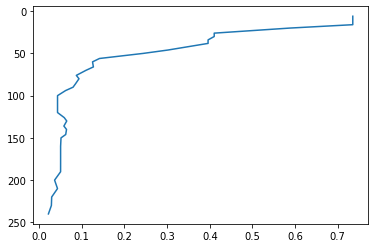

In [1348]:
# Let's start with the shape of the Chla profile
# plot some data
tmp = data[data.id == 20] # choose a profil ID here 
tmp = tmp[tmp.depth < 250]

#tmp.plot.scatter(x = 'chla', y = 'depth')
from matplotlib import pyplot as plt
plt.gca().invert_yaxis()
plt.plot(tmp['chla'], tmp['depth'])

In [1349]:
# based on some profiles, I decided to put the threshold of Chla at 0.1 mg/m³ (pay attention to the units in Morel et al., 2001)
# compare the value of the depth found here with the one of Morel, should be close. Let's also compute the empirical equation to see.
chla_threshold = 0.1

## NOTE : not sure it's the good way to go

In [1350]:
z_eu_chla_threshold = min(tmp[tmp.chla < chla_threshold].depth)
z_eu_chla_threshold

76.0

### B) Based on empirical relationship

In [1351]:
chla_10m = float(tmp.iloc[(tmp['depth']-10).abs().argsort()[:1]]['chla']) # chla at ~ 10 m (or the closest)
z_eu_empir = 1/(0.012939+(0.018151*chla_10m))
z_eu_empir

38.04773371490816

### C) Morel's method (to be done)

# Which method is the best to compute a z_eu ? Needs to be discussed

In [1352]:
# compute the z_eu for each profile, I'm choosing the satellite method (empirical)
def compute_z_eu(group):
    chla_10m = float(group.iloc[(group['depth']-10).abs().argsort()[:1]]['chla']) # chla at ~ 10 m (or the closest)
    z_eu_empir = 1/(0.012939+(0.018151*chla_10m))
    group['z_eu'] = z_eu_empir
    return(group)

In [1353]:
data = data.groupby('id').apply(compute_z_eu)

In [1354]:
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,time,lat,lon,wmo,id,sigma,MLD,poc,human_time,z_eu
1,6,1,7.332,1,35.239,1,0.0791231,NaN,0.000355,2,22223.943646,70.030,6.017,6900799,1,27.562237,152.000000,0.013340,2010-11-05,69.564424
3,10,1,7.335,1,35.239,1,0.0791231,NaN,0.000352,2,22223.943646,70.030,6.017,6900799,1,27.561864,152.000000,0.013217,2010-11-05,69.564424
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000347,2,22223.943646,70.030,6.017,6900799,1,27.561919,152.000000,0.013020,2010-11-05,69.564424
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000344,2,22223.943646,70.030,6.017,6900799,1,27.561803,152.000000,0.012895,2010-11-05,69.564424
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000343,2,22223.943646,70.030,6.017,6900799,1,27.561924,152.000000,0.012880,2010-11-05,69.564424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,28.030026,36.099998,0.003229,2013-09-20,33.413151
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000102,2,23273.949641,71.147,5.378,6900799,156,28.034584,36.099998,0.003235,2013-09-20,33.413151
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,28.039885,36.099998,0.003625,2013-09-20,33.413151
106509,1150.68,1,-0.29302,8,34.896,8,0.0144,NaN,0.000115,2,23273.949641,71.147,5.378,6900799,156,28.043403,36.099998,0.003625,2013-09-20,33.413151


## Thickness of the layer where particles can potentially be produced by photosynthesis

In [1355]:
# I am gonna keep the empirical z_eu
def compute_zp(group):
    z_p = max(min(group['MLD']), min(group['z_eu']))
    group['z_p'] = z_p
    return(group)

In [1356]:
data = data.groupby('id').apply(compute_zp)

In [1357]:
# np.unique(data[data.MLD > 200]['human_time'])
# np.unique(data[data.MLD > 200]['MLD'])

# Check that flux is ~ 0 at 1000m (see hypotheses)
- For those two floats, it is the case but this step needs to be reminded when going global

# Integration of POC in different layers

In [1358]:
tmp = data[data.id == 20]
tmp

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,...,lat,lon,wmo,id,sigma,MLD,poc,human_time,z_eu,z_p
12978,6,1,6.529,1,35.205,1,0.735154,NaN,0.002332,2,...,69.841,5.588,6900799,20,27.646975,36.0,0.087524,2011-05-14,38.047734,38.047734
12980,10,1,6.393,1,35.209,1,0.735154,NaN,0.001682,2,...,69.841,5.588,6900799,20,27.668359,36.0,0.063127,2011-05-14,38.047734,38.047734
12983,16,1,6.291,1,35.208,1,0.735154,NaN,0.001295,2,...,69.841,5.588,6900799,20,27.681139,36.0,0.048601,2011-05-14,38.047734,38.047734
12985,20,1,6.266,1,35.209,1,0.587626,NaN,0.001231,2,...,69.841,5.588,6900799,20,27.685266,36.0,0.046194,2011-05-14,38.047734,38.047734
12988,26,1,6.25,1,35.209,1,0.4104,NaN,0.001156,2,...,69.841,5.588,6900799,20,27.687555,36.0,0.043389,2011-05-14,38.047734,38.047734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13476,1000,1,0.277,1,34.9,1,0.0144,NaN,0.000068,2,...,69.841,5.588,6900799,20,28.015867,36.0,0.002165,2011-05-14,38.047734,38.047734
13501,1050,1,0.071,1,34.895,1,0.0144,NaN,0.000078,2,...,69.841,5.588,6900799,20,28.023438,36.0,0.002476,2011-05-14,38.047734,38.047734
13526,1100,1,-0.044,1,34.895,1,0.0144,NaN,0.000078,2,...,69.841,5.588,6900799,20,28.029743,36.0,0.002476,2011-05-14,38.047734,38.047734
13551,1150,1,-0.152,1,34.896,1,0.00720715,NaN,0.000079,2,...,69.841,5.588,6900799,20,28.036318,36.0,0.002484,2011-05-14,38.047734,38.047734


In [1359]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simps.html
# https://en.wikipedia.org/wiki/Simpson%27s_rule

# integration over the whole profile (just a check)
x = np.array(tmp['depth'])
y = np.array(tmp['poc'])
from scipy import integrate
integrate.simps(y,x)

6.056289476914836

In [1360]:
def integrate_poc(depth_min, depth_max, data):
    data = data[(data.depth > depth_min) & (data.depth < depth_max)]
    x = np.array(data.depth)
    y = np.array(data.poc)
    return(integrate.simps(y,x))

In [1361]:
def compute_carbon_stocks(group):
    
    # 0-1000m => check in the paper iPOC_0_1000 
    iPOC_0_1000 = integrate_poc(0, 1000, group)
    group['iPOC_0_1000'] = iPOC_0_1000
    
    # 0 -> zp : 'productive layer' or iPOC_0_zp
    zp = min(group['z_p'])
    iPOC_0_zp = integrate_poc(0, zp, group)
    group['iPOC_0_zp'] = iPOC_0_zp
    
    # zp -> 1000m : 'mesopelagic layer' or iPOC_zp_1000
    iPOC_zp_1000 = integrate_poc(zp, 1000, group)
    group['iPOC_zp_1000'] = iPOC_zp_1000
    
    # other stocks in the meso layer such as iPOC_zp+zi_1000
    # zi = 50, 100, 200, 300, 400
    
    zi = 50 
    try: # needed to be added when MLD is so deep that we are close to z_max (i.e. 1000m) hence flux integration can be buggy
        iPOC_zpzi50_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi50_1000'] = iPOC_zpzi50_1000
    except:
        group['iPOC_zp+zi50_1000'] = 'NaN'
    
    zi = 100
    try:
        iPOC_zpzi100_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi100_1000'] = iPOC_zpzi100_1000
    except:
        group['iPOC_zp+zi100_1000'] = 'NaN'
    
    zi = 200
    try:
        iPOC_zpzi200_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi200_1000'] = iPOC_zpzi200_1000
    except:
        group['iPOC_zp+zi200_1000'] = 'NaN'
    
    zi = 300
    try: 
        iPOC_zpzi300_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi300_1000'] = iPOC_zpzi300_1000
    except:
        group['iPOC_zp+zi300_1000'] = 'NaN'
    
    zi = 400
    try:
        iPOC_zpzi400_1000 = integrate_poc(zp+zi, 1000, group)
        group['iPOC_zp+zi400_1000'] = iPOC_zpzi400_1000
    except:
        group['iPOC_zp+zi400_1000'] = 'NaN'
    
    return(group)

In [1362]:
#import ipdb; ipdb.set_trace() # debugging starts here

In [1363]:
data = data.groupby('id').apply(compute_carbon_stocks)
data

,depth,depth_qc,temp,temp_qc,psal,psal_qc,chla,chla_qc,bbp,bbp_qc,...,z_eu,z_p,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000
1,6,1,7.332,1,35.239,1,0.0791231,NaN,0.000355,2,...,69.564424,152.000000,6.049159,1.864964,4.068656,3.560415,3.083341,2.31659,1.6737,1.23156
3,10,1,7.335,1,35.239,1,0.0791231,NaN,0.000352,2,...,69.564424,152.000000,6.049159,1.864964,4.068656,3.560415,3.083341,2.31659,1.6737,1.23156
5,14,1,7.335,1,35.239,1,0.0791231,NaN,0.000347,2,...,69.564424,152.000000,6.049159,1.864964,4.068656,3.560415,3.083341,2.31659,1.6737,1.23156
6,16,1,7.336,1,35.239,1,0.0739986,NaN,0.000344,2,...,69.564424,152.000000,6.049159,1.864964,4.068656,3.560415,3.083341,2.31659,1.6737,1.23156
9,22,1,7.336,1,35.239,1,0.072,NaN,0.000343,2,...,69.564424,152.000000,6.049159,1.864964,4.068656,3.560415,3.083341,2.31659,1.6737,1.23156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106427,993.62,1,-0.0410857,8,34.896,8,0.0144,NaN,0.000102,2,...,33.413151,36.099998,5.821422,1.385472,4.089417,3.457271,3.098025,2.45662,1.87395,1.4772
106454,1045.8,1,-0.140684,8,34.895,8,0.0144,NaN,0.000102,2,...,33.413151,36.099998,5.821422,1.385472,4.089417,3.457271,3.098025,2.45662,1.87395,1.4772
106483,1100.63,1,-0.22563,8,34.896,8,0.0144,NaN,0.000115,2,...,33.413151,36.099998,5.821422,1.385472,4.089417,3.457271,3.098025,2.45662,1.87395,1.4772
106509,1150.68,1,-0.29302,8,34.896,8,0.0144,NaN,0.000115,2,...,33.413151,36.099998,5.821422,1.385472,4.089417,3.457271,3.098025,2.45662,1.87395,1.4772


In [1364]:
# check stock max 
max(data['iPOC_0_1000'])

21.500374496462406

In [1365]:
# let's just plot full stock (0-1000) over time to see if the trends are consistent with the paper
test = data[['human_time', 'iPOC_0_1000']].drop_duplicates()
test

,human_time,iPOC_0_1000
1,2010-11-05,6.049159
684,2010-11-15,5.107205
1367,2010-11-25,4.914533
2051,2010-12-05,4.249216
2734,2010-12-15,4.445069
...,...,...
103135,2013-08-31,6.327355
103818,2013-09-05,7.516922
104501,2013-09-10,7.682400
105184,2013-09-15,7.570684


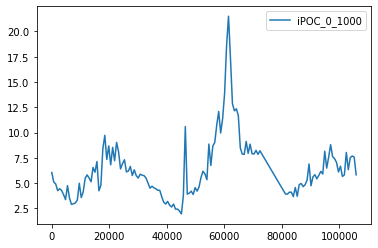

In [1366]:
# attention, total stock has been SMOOTHED so the pic was surely erased in Fig. 3
test.plot()

# Let's (try to) replicate Fig. 2

In [1367]:
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import dates

from datetime import datetime, timedelta
from datetime import date

import cmocean
import matplotlib.dates as mdates

In [1368]:
# data to plot
x = np.array(data['human_time'])
y = np.array(data['depth'])
z = np.array(data['bbp'])

# compute log10 BBP
# import math
# z = math.log10(z)
# see https://stackoverflow.com/questions/47208473/attributeerror-numpy-float64-object-has-no-attribute-log10/47208873#47208873
z = np.log10(z.astype(np.float64))
# np.log10(list(z)) # also work but np.log10(z) does NOT work


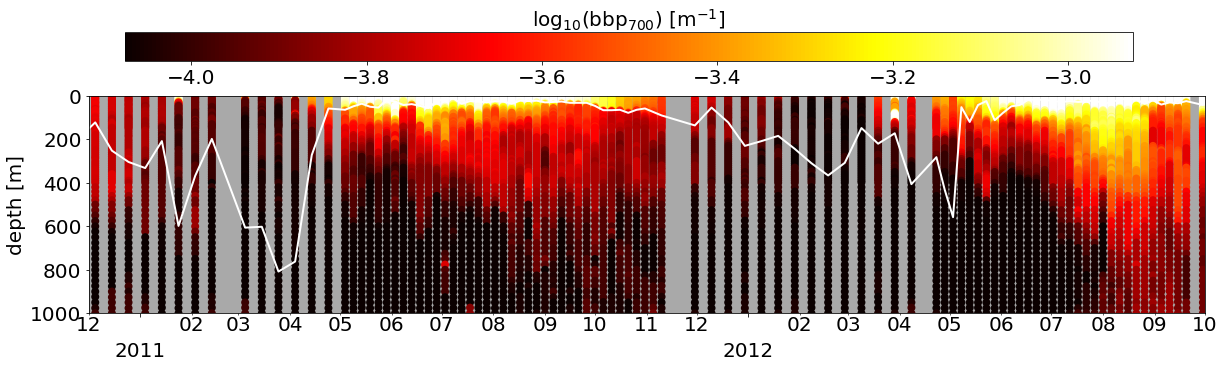

In [1369]:
# cmap = cmocean.cm.tempo_r
# cmap = mpl.cm.RdYlBu
# cmap = mpl.cm.RdYlBu_r
# cmap = mpl.cm.jet
# cmap = mpl.cm.magma
cmap = mpl.cm.hot


vmin = np.percentile(z, 15) # "min color range"
vmax = np.percentile(z, 95) 
ymax = 1000 # depth max to plot
title = '$\log_{10}$(bbp$_{700}$) [m$^{-1}$]'

# see matplotlib tuto at https://matplotlib.org/3.3.2/tutorials/introductory/usage.html

fig, ax = plt.subplots(figsize=(20, 4)) # Create a figure containing a single axes.
ax.set_facecolor('darkgrey')
# fig = plt.figure(1, figsize=(20, 6))
# ax = fig.add_subplot(111, axisbg='#E6E6E6')
ax.scatter(x, y, s=64, c=z, marker='o', edgecolors='none', vmin=vmin, vmax=vmax, cmap=cmap) # Plot data on the axes.
ax.set_ylabel('depth [m]', fontsize = 20)
#ax.set_title(title, fontsize = 20)
ylim([0, ymax])
plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data
mld = np.array(data[['MLD', 'human_time']].drop_duplicates().MLD)
time_mld = np.array(data[['MLD', 'human_time']].drop_duplicates().human_time)
ax.plot(time_mld, mld, 'w-', lw = 2)

# add colorbar
ax1 = fig.add_axes([0.15, 1, .7, .1]) # left (+ for left), up (+ for up), length, thickness

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                       norm=norm,
                       orientation='horizontal')

cb1.ax.set_title(title, fontsize = 20)
cb1.ax.tick_params(labelsize=20) 

imaxes = gca()
axes(cb1.ax)
axes(imaxes)

In [1370]:
fname = 'figs/Fig2_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

# What about Fig. 3?

In [1371]:
data.columns

Index(['depth', 'depth_qc', 'temp', 'temp_qc', 'psal', 'psal_qc', 'chla',
       'chla_qc', 'bbp', 'bbp_qc', 'time', 'lat', 'lon', 'wmo', 'id', 'sigma',
       'MLD', 'poc', 'human_time', 'z_eu', 'z_p', 'iPOC_0_1000', 'iPOC_0_zp',
       'iPOC_zp_1000', 'iPOC_zp+zi50_1000', 'iPOC_zp+zi100_1000',
       'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000'],
      dtype='object')

In [1372]:
data2 = data[['human_time', 'iPOC_0_1000', 'iPOC_0_zp','iPOC_zp_1000','iPOC_zp+zi50_1000',
             'iPOC_zp+zi100_1000', 'iPOC_zp+zi200_1000', 'iPOC_zp+zi300_1000', 'iPOC_zp+zi400_1000',
             'MLD']].drop_duplicates()
data2

,human_time,iPOC_0_1000,iPOC_0_zp,iPOC_zp_1000,iPOC_zp+zi50_1000,iPOC_zp+zi100_1000,iPOC_zp+zi200_1000,iPOC_zp+zi300_1000,iPOC_zp+zi400_1000,MLD
1,2010-11-05,6.049159,1.864964,4.068656,3.560415,3.083341,2.31659,1.6737,1.23156,152.000000
684,2010-11-15,5.107205,1.384293,3.558297,3.237183,2.897991,2.26429,1.6101,1.21684,160.000000
1367,2010-11-25,4.914533,1.556552,3.279469,2.959042,2.650970,2.0326,1.52285,1.11373,196.000000
2051,2010-12-05,4.249216,0.892210,3.316080,2.991125,2.701309,2.11294,1.47533,1.07221,122.000000
2734,2010-12-15,4.445069,1.643834,2.739708,2.471392,2.193255,1.5783,1.08691,0.789408,252.000000
...,...,...,...,...,...,...,...,...,...,...
103135,2013-08-31,6.327355,1.767604,4.110399,3.683783,3.283679,2.59611,1.95257,1.45087,35.310001
103818,2013-09-05,7.516922,3.203918,4.089903,3.702558,3.288557,2.65797,2.05654,1.51174,48.000000
104501,2013-09-10,7.682400,3.344591,4.027019,3.599279,3.234180,2.58288,1.98437,1.54687,48.000000
105184,2013-09-15,7.570684,3.504290,3.760457,3.414865,3.128480,2.4594,1.84033,1.36405,48.000000


In [1373]:
# remove NaN otherwise matplotlib will not work. It should only concerns stocks that are NaN which is the same as 0
data2 = data2.replace('NaN', 0)

# data to plot
x = np.array(data2['human_time'])
iPOC_0_1000 = np.array(data2['iPOC_0_1000'])
iPOC_0_zp = np.array(data2['iPOC_0_zp'])
iPOC_zp_1000 = np.array(data2['iPOC_zp_1000'])
iPOC_zpzi50_1000 = np.array(data2['iPOC_zp+zi50_1000'])
iPOC_zpzi100_1000 = np.array(data2['iPOC_zp+zi100_1000'])
iPOC_zpzi200_1000 = np.array(data2['iPOC_zp+zi200_1000'])
iPOC_zpzi300_1000 = np.array(data2['iPOC_zp+zi300_1000'])
iPOC_zpzi400_1000 = np.array(data2['iPOC_zp+zi400_1000'])

# add MLD data
mld = np.array(data2['MLD'])
time_mld = np.array(data2['human_time'])

In [1374]:
# sns.palplot(sns.light_palette("grey", reverse=True))

In [1375]:
import seaborn as sns
pal = sns.light_palette("grey", reverse=True)
pal = sns.dark_palette("green", reverse=True)

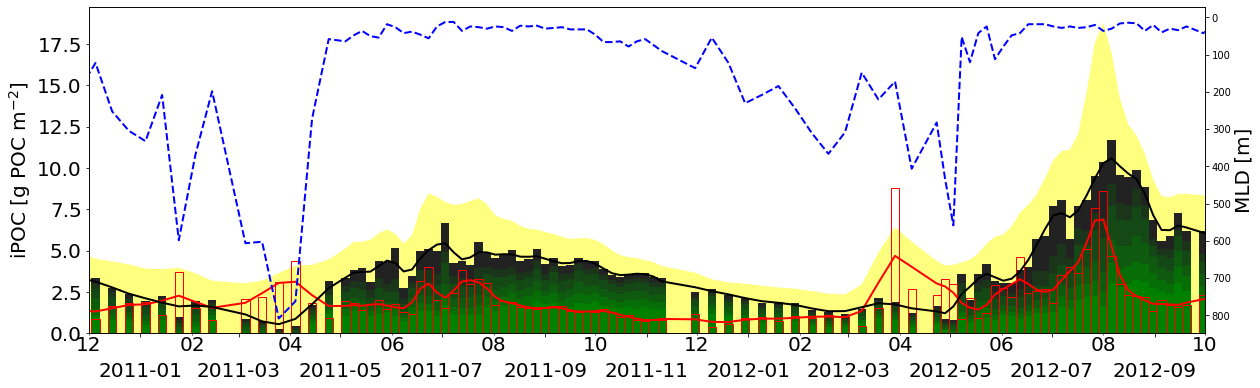

In [1376]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()
w = 5

#ax.plot(x, iPOC_0_1000) # Plot data on the axes.
# ax.bar(x, iPOC_zp_1000, width = w, color = pal[0])
# ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[1])
# ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[2])
# ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[3])
# ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[4])
# ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[5])

ax.bar(x, iPOC_zp_1000, width = w, color = pal[5])
ax.bar(x, iPOC_zpzi50_1000, width = w, color = pal[4])
ax.bar(x, iPOC_zpzi100_1000, width = w, color = pal[3])
ax.bar(x, iPOC_zpzi200_1000, width = w, color = pal[2])
ax.bar(x, iPOC_zpzi300_1000, width = w, color = pal[1])
ax.bar(x, iPOC_zpzi400_1000, width = w, color = pal[0])

# iPOC in the upper layer
iPOC_0_zp_s = gaussian_filter1d(iPOC_0_zp, 1) # smoothed
ax.plot(x, iPOC_0_zp_s, color = 'red', lw = 2)
ax.bar(x, iPOC_0_zp, width = w, color = "None", edgecolor = 'red')

ax.set_ylabel('iPOC [g POC m$^{-2}$]', fontsize = 20)

# iPOC zp -> 1000
iPOC_zp_1000_s = gaussian_filter1d(iPOC_zp_1000, 1) # smoothed
ax.plot(x, iPOC_zp_1000_s, color = 'black', lw = 2)

# add (not smoothed) iPOC_0_1000
# Shade the area between y1 and line y=0

# try to smooth iPOC_0_1000
from scipy.signal import savgol_filter
# iPOC_0_1000_s = savgol_filter(iPOC_0_1000, 15, 3)
# iPOC_0_1000_s = signal.medfilt(iPOC_0_1000, 11)
from scipy.ndimage import gaussian_filter1d
iPOC_0_1000_s = gaussian_filter1d(iPOC_0_1000, 1)
ax.fill_between(x, y1 = iPOC_0_1000_s, facecolor="yellow", alpha=.5) # The outline color

# import seaborn as sns
# seq_col_brew = sns.color_palette("gray", 5)
# sns.set_palette(seq_col_brew)

# ax.set_title(title, fontsize = 20)
# ylim([0, ymax])
# plt.gca().invert_yaxis()

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
plt.gca().invert_yaxis()

fname = 'figs/Fig3up_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

# Compute instantaneous fluxes (reminder : hyp that flux is 0 at 1000 m)

In [1377]:
def compute_flux(dataset, var_name):
    fluxes = []
    
    for i in range(dataset.shape[0]):
        if(i == 0): 
            fluxes.append(0)
        else:
            deltaIPOC = dataset.iloc[i].loc[var_name] - dataset.iloc[i-1].loc[var_name]
            deltaT = relativedelta(dataset.iloc[i].loc['human_time'], dataset.iloc[i-1].loc['human_time'])
            deltaT = deltaT.days
            flux = (deltaIPOC/deltaT)*1000 # *100 to get mg instead of g
            fluxes.append(flux)
    return(fluxes)

In [1378]:
data3 = data2.copy()
tmp = gaussian_filter1d(data3['iPOC_0_zp'], 1) # smoothed
data3['iPOC_0_zp'] = tmp
data3['flux_0_zp'] = compute_flux(data3, 'iPOC_0_zp')

# other
tmp = gaussian_filter1d(data2['iPOC_zp+zi50_1000'],1)
data3['iPOC_zp+zi50_1000'] = tmp
data3['flux_zpzi50_1000'] = compute_flux(data3, 'iPOC_zp+zi50_1000')

# other
tmp = gaussian_filter1d(data2['iPOC_zp+zi100_1000'],1)
data3['iPOC_zp+zi100_1000'] = tmp
data3['flux_zpzi100_1000'] = compute_flux(data3, 'iPOC_zp+zi100_1000')

# other
tmp = gaussian_filter1d(data2['iPOC_zp+zi200_1000'],1)
data3['iPOC_zp+zi200_1000'] = tmp
data3['flux_zpzi200_1000'] = compute_flux(data3, 'iPOC_zp+zi200_1000')

# other
tmp = gaussian_filter1d(data2['iPOC_zp+zi300_1000'],1)
data3['iPOC_zp+zi300_1000'] = tmp
data3['flux_zpzi300_1000'] = compute_flux(data3, 'iPOC_zp+zi300_1000')

tmp = gaussian_filter1d(data2['iPOC_zp+zi400_1000'],1)
data3['iPOC_zp+zi400_1000'] = tmp
data3['flux_zpzi400_1000'] = compute_flux(data3, 'iPOC_zp+zi400_1000')


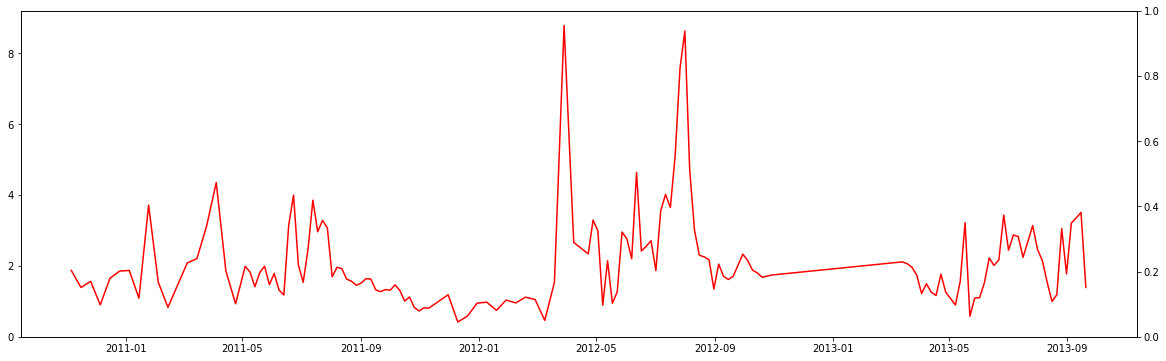

In [1379]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()
ax.plot(x, iPOC_0_zp, color = 'red')

In [1380]:
# # apply smoothing filter on the time series of stocks before computing the derivatives
# data2['iPOC_zp+zi50_1000'] = gaussian_filter1d(data2['iPOC_zp+zi50_1000'],1)
# data2['iPOC_zp+zi100_1000'] = gaussian_filter1d(data2['iPOC_zp+zi100_1000'],1)
# data2['iPOC_zp+zi200_1000'] = gaussian_filter1d(data2['iPOC_zp+zi200_1000'],1)
# data2['iPOC_zp+zi300_1000'] = gaussian_filter1d(data2['iPOC_zp+zi300_1000'],1)
# data2['iPOC_zp+zi400_1000'] = gaussian_filter1d(data2['iPOC_zp+zi400_1000'],1)
# data2['iPOC_0_zp'] = gaussian_filter1d(data2['iPOC_0_zp'],1)

In [1381]:
# data2['flux_zpzi50_1000'] = compute_flux(data2, 'iPOC_zp+zi50_1000')
# data2['flux_zpzi100_1000'] = compute_flux(data2, 'iPOC_zp+zi100_1000')
# data2['flux_zpzi200_1000'] = compute_flux(data2, 'iPOC_zp+zi200_1000')
# data2['flux_zpzi300_1000'] = compute_flux(data2, 'iPOC_zp+zi300_1000')
# data2['flux_zpzi400_1000'] = compute_flux(data2, 'iPOC_zp+zi400_1000')
# data2['flux_0_zp'] = compute_flux(data2, 'iPOC_0_zp')

In [1382]:
# data2.head()

In [1383]:
# data to plot
x = np.array(data2['human_time'])
flux_zpzi50_1000 = np.array(data3['flux_zpzi50_1000'])
flux_zpzi100_1000 = np.array(data3['flux_zpzi100_1000'])
flux_zpzi200_1000 = np.array(data3['flux_zpzi200_1000'])
flux_zpzi300_1000 = np.array(data3['flux_zpzi300_1000'])
flux_zpzi400_1000 = np.array(data3['flux_zpzi400_1000'])
flux_0_zp = np.array(data3['flux_0_zp'])

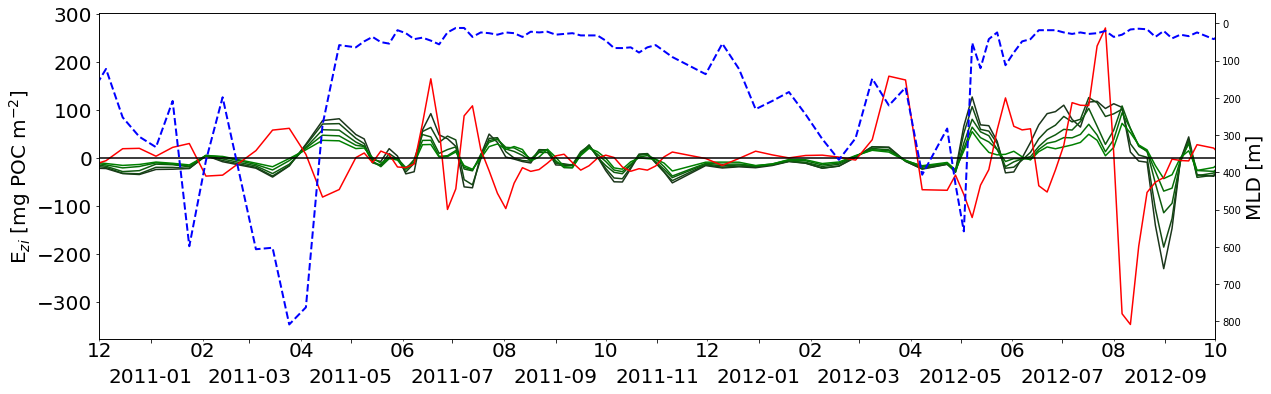

In [1384]:
fig, ax = plt.subplots(figsize = (20,6))
ax2 = ax.twinx()

ax.plot(x, flux_zpzi50_1000, color = pal[4])
ax.plot(x, flux_zpzi100_1000, color = pal[3])
ax.plot(x, flux_zpzi200_1000, color = pal[2])
ax.plot(x, flux_zpzi300_1000, color = pal[1])
ax.plot(x, flux_zpzi400_1000, color = pal[0])
ax.plot(x, flux_0_zp, color = 'red')
#iPOC_0_zp_test
ax.set_ylabel('E$_{zi}$ [mg POC m$^{-2}$]', fontsize = 20)

#####   set ticks and  labels
months = mdates.MonthLocator(interval=1)
years = mdates.YearLocator() 

datemin = datetime.strptime('2010-12-01', '%Y-%m-%d').date()
datemin = datemin.toordinal()
datemax = datetime.strptime('2012-10-01', '%Y-%m-%d').date()
datemax = datemax.toordinal()

ax.set_xlim(datemin, datemax)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_locator(years)
fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(fmt)

ax.tick_params(axis='x', which='major', direction='out', pad=25, labelsize=20)
ax.tick_params(axis='x', which='minor', direction='out', pad=0.5, labelsize=20)
ax.tick_params(axis='both', which='both', labelsize=20)

# add mld data (on another axes)
ax2.plot(time_mld, mld, 'b--', lw = 2)
ax2.set_ylabel('MLD [m]', fontsize = 20)
plt.gca().invert_yaxis()

# add horizontal line
ax.axhline(y = 0, color = 'black')

fname = 'figs/Fig3down_'+str(wmo)    
fig.set_size_inches(20, 6)
fig.savefig(fname, dpi = 75)

# TO DO
- 1. compute the depth of the bottom of the euphotic zone (3 différents ways possible but two to really compare) => needs to be discussed and tested with the method of Lionel for the determination of z_eu
- 2. finalize the check for no POC at 1000m